In [4]:
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import *
from seaborn import FacetGrid, factorplot
from pylab import figure, text, scatter, show
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import *
import seaborn as sb
sb.set(font_scale=3)
from seaborn import FacetGrid, factorplot
from pylab import figure, text, scatter, show
sb.set(font_scale=3)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import itertools
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [5]:
#machine learning results comparison

In [6]:
df = pd.DataFrame(index=['black&white', 'black', 'white'])
df['Accuracy'] = [0.5995525727069351, 0.6573754316724223, 0.713078618662748]
df['Accuracy'] = df['Accuracy'].astype(float).map("{:.2%}".format)

In [7]:
df['False postive'] = [0.1644295302013423, 0.15964523281596452, 0.08250825082508251]
df['False postive'] = df['False postive'].astype(float).map("{:.2%}".format)

In [8]:
df['False negative'] = [0.2360178970917226,0.17738359201773837, 0.1848184818481848]
df['False negative'] = df['False negative'].astype(float).map("{:.2%}".format)

In [9]:
df

,Accuracy,False postive,False negative
black&white,59.96%,16.44%,23.60%
black,65.74%,15.96%,17.74%
white,71.31%,8.25%,18.48%


In [10]:
#data preprocessing

In [11]:
df = pd.read_csv("compas-scores-two-years.csv")
df = df[(df['days_b_screening_arrest'] >= -30) & (df['days_b_screening_arrest'] <= 30) & (df['is_recid'] != -1) & 
      (df['c_charge_degree'] != 'O') & (df['score_text'] != 'N/A')]

df = df.iloc[:,[5,7,8,9,11,24,33,40,43,44,51,52]]

df.loc[df['decile_score'] <  8, 'p_recid'] = 0
df.loc[df['decile_score'] >=  8, 'p_recid'] = 1
df['p_recid'] = df['p_recid'].astype(int)

df.loc[df['v_decile_score'] <  8, 'v_p_recid'] = 0
df.loc[df['v_decile_score'] >=  8, 'v_p_recid'] = 1
df['v_p_recid'] = df['v_p_recid'].astype(int)


In [12]:
black = df.loc[df['race'] == 'African-American']
black['sex'] = black.sex.apply(lambda x: 0 if x=='Male' else 1)
black = black.drop(['race','age_cat', 'score_text','v_score_text'], axis=1)

In [13]:
X_train = black.drop('is_recid', axis=1)
X_test = black.drop('is_recid', axis=1)
y_train = black['is_recid']
y_test = black['is_recid']

def model_mse(model):
    fit_model = model().fit(X_train, y_train)
    MSE = mean_squared_error(fit_model.predict(X_test), y_test)
    mse = "The test MSE of this model is: " + str(MSE)
    return mse, fit_model

In [14]:
model_mse(LinearRegression)

('The test MSE of this model is: 0.02774195250642864',
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

In [15]:
para_ridge = {'alpha':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
ridge_regressor = GridSearchCV(Ridge(), para_ridge, scoring='neg_mean_squared_error', cv=10)
ridge_regressor.fit(X_train, y_train)
mse_ridge = mean_squared_error(ridge_regressor.predict(X_test), y_test)
print('The test MSE for ridge regression is', mse_ridge)

The test MSE for ridge regression is 0.027742347949400607


In [16]:
#raw data features

In [17]:
df2 = df.loc[(df['race'] != 'Asian') & (df['race'] != 'Other') & (df['race'] != 'Native American') & (df['race'] != 'Hispanic')]
df2['high'] = 0
df2['low'] = 0

In [21]:
df2 = df.loc[(df['race'] != 'Asian') & (df['race'] != 'Other') & (df['race'] != 'Native American') & (df['race'] != 'Hispanic')]
df_group = pd.DataFrame(df2.groupby(['score_text','race','is_recid'])['is_recid'].count().unstack())
df_group['total'] = df_group[0] + df_group[1]
df_group['Likelihood of Recidivism'] = df_group[1]/df_group['total']

df2v = df.loc[(df['race'] != 'Asian') & (df['race'] != 'Other') & (df['race'] != 'Native American')& (df['race'] != 'Hispanic')]
df_groupv = pd.DataFrame(df2v.groupby(['v_score_text','race','is_violent_recid'])['is_recid'].count().unstack())
df_groupv['total'] = df_groupv[0] + df_groupv[1]
df_groupv['Likelihood of Recidivism'] = df_groupv[1]/df_groupv['total']

In [27]:
df2['high'] = 0
df2['low'] = 0
aa = df2.loc[df2.race == "African-American"]
w = df2.loc[df2.race == "Caucasian"]

aa.loc[aa['score_text'] ==  'High', 'high'] = 1
aa.loc[aa['score_text'] ==  'Medium', 'medium'] = 1
aa.loc[aa['score_text'] ==  'Low', 'low'] = 1


aa_low = confusion_matrix(aa.low,aa.is_recid)
aa_high = confusion_matrix(aa.high,aa.is_recid)

w_low = confusion_matrix(w.low,w.is_recid)
w_high = confusion_matrix(w.high,w.is_recid)


w.loc[w['score_text'] ==  'High', 'high'] = 1
w.loc[w['score_text'] ==  'Low', 'low'] = 1

In [31]:
aa_high_FP, aa_low_FN = round(aa_high[1][0]/np.sum(aa_high)*100,2), round(aa_low[1][1]/np.sum(aa_low)*100,2)
w_high_FP, w_low_FN = round(w_high[1][0]/np.sum(w_high)*100,2), round(w_low[1][1]/np.sum(w_low)*100,2)

aa_ppv = precision_score(aa['is_recid'],aa['p_recid'])*100
w_ppv = precision_score(w['is_recid'],w['p_recid'])*100

aa_npv, w_npv = 100 - aa_ppv, 100 - w_ppv

In [32]:

b_high_FP, b_low_FN = round(b_high[1][0]/np.sum(b_high)*100,2), round(b_low[1][1]/np.sum(b_low)*100,2)
w_high_FP, w_low_FN = round(w_high[1][0]/np.sum(w_high)*100,2), round(w_low[1][1]/np.sum(w_low)*100,2)

In [33]:
#FP&FN for two races

In [34]:
cols = ['Race','Metric', 'Score %']
x = pd.DataFrame(np.zeros((4, 3)), columns=cols)
x['Race'] = ['African-American','Caucasian'] * 2
x['Metric'] = ['False Positive','False Positive','False Negative','False Negative']
x['Score %'] = [aa_high_FP,w_high_FP,aa_low_FN,w_low_FN]

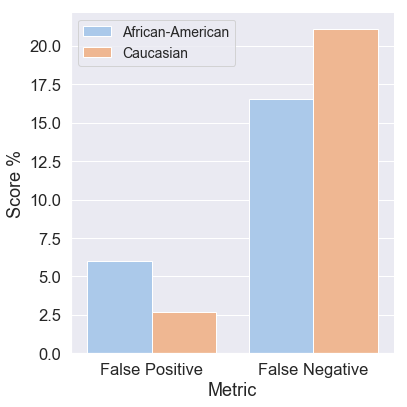

In [35]:
sb.set(font_scale=1.5)
ax = factorplot(x='Metric', y='Score %', hue='Race', data=x, kind='bar', palette= "pastel", size = 6, aspect = 1, 
                legend = False) 
plt.legend(loc='upper left', prop={'size': 14})
plt.show()

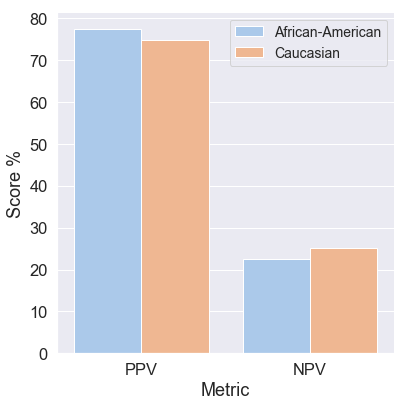

In [36]:
xx = x
xx['Metric'] = ['PPV','PPV','NPV','NPV']
xx['Score %'] = [aa_ppv,w_ppv,aa_npv,w_npv]

sb.set(font_scale=1.5)
ax = factorplot(x='Metric', y='Score %', hue='Race', data=xx, kind='bar',palette= "pastel", size = 6, aspect = 1, 
                legend = False) 
plt.legend(loc='upper right', prop={'size': 14})
plt.show()

Get the ROC and AUC values for the COMPAS prediction system by race

In [48]:
y_true = df['is_recid']
y_probas = df['decile_score']
fpr, tpr, thresholds = roc_curve(y_true, y_probas, pos_label=0)

In [49]:
afpr, atpr, athresholds = roc_curve(aa['is_recid'], aa['decile_score'], pos_label=0)
wfpr, wtpr, wthresholds = roc_curve(w['is_recid'], w['decile_score'], pos_label=0)
aauc = np.trapz(afpr, atpr)
wauc = np.trapz(wfpr, wtpr)

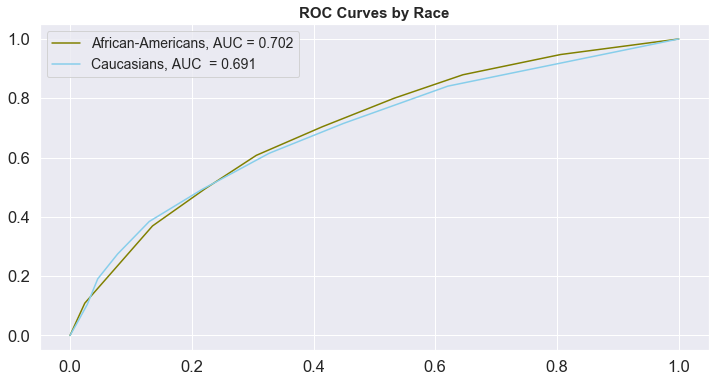

In [50]:
sb.set(font_scale=1.5)
plt.figure(figsize=(12,6))
plt.plot(atpr,afpr,color='olive',label="African-Americans, AUC = "+str(round(aauc,3)))
plt.plot(wtpr,wfpr,color='skyblue',label="Caucasians, AUC  = "+ str(round(wauc,3)))
plt.title("ROC Curves by Race", fontsize = 15, fontweight= "bold")
plt.legend(loc='upper left', prop={'size': 14})
plt.show()